In [ ]:
# ================================================================
# 0. Setup: libs & GPU check
# ================================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow version:", tf.__version__)
print("Num GPUs:", len(tf.config.list_physical_devices('GPU')))


# ================================================================
# 1. Mount Google Drive and define paths
# ================================================================
from google.colab import drive
drive.mount('/content/drive')

# TODO: change this to your folder on Drive
BASE_DIR = "/content/drive/MyDrive/ANN_Challenge_2"


TRAIN_IMG_DIR = os.path.join(BASE_DIR, "train_data")
TEST_IMG_DIR  = os.path.join(BASE_DIR, "test_data")
LABELS_CSV    = os.path.join(BASE_DIR, "train_labels.csv")

print("Train dir:", TRAIN_IMG_DIR)
print("Test dir:", TEST_IMG_DIR)
print("Labels csv:", LABELS_CSV)


# ================================================================
# 2. Load labels and build DataFrame with image paths
# ================================================================
df = pd.read_csv(LABELS_CSV)
df.head()

# Try to infer column names (adjust if necessary)
print(df.columns)

# If the column is called 'sample_index', rename it for convenience
if "sample_index" in df.columns and "image_id" not in df.columns:
  df = df.rename(columns={"sample_index": "image_id"})

TensorFlow version: 2.19.0
Num GPUs: 1
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train dir: /content/drive/MyDrive/ANN_Challenge_2/train_data
Test dir: /content/drive/MyDrive/ANN_Challenge_2/test_data
Labels csv: /content/drive/MyDrive/ANN_Challenge_2/train_labels.csv
Index(['sample_index', 'label'], dtype='object')


In [ ]:
# Build image path column
# We assume image files are something like "<image_id>.png"
# Adjust extension if needed (.jpg, .tif, ...)
IMG_EXT = ".png"  # TODO: change if needed

''' def build_img_filename(x):
  """Return filename with exactly one extension."""
  x = str(x)
  root, ext = os.path.splitext(x)
  if ext == "":         # no extension in CSV -> add .png
    return root + IMG_EXT
  else:                 # extension already there -> keep it
    return root + ext

df["img_path"] = df["image_id"].apply(build_img_filename)
df["img_path"] = df["img_path"].apply(lambda x: os.path.join(TRAIN_IMG_DIR, x))


# Optional: build mask path (only if you want to use masks)
def build_mask_path(img_path):
  dirname, filename = os.path.split(img_path)
  name, ext = os.path.splitext(filename)
  mask_name = name + "_mask" + ext   # qui non aggiungiamo niente di extra
  return os.path.join(dirname, mask_name)

df["mask_path"] = df["img_path"].apply(build_mask_path) '''


def make_image_filename(x: str) -> str:
    """Ensure x is a filename like 'img_0000.png'."""
    x = str(x)
    # If it already ends with .png, keep it
    if x.endswith(".png"):
        return x
    # If it's something like 'img_0000'
    if x.startswith("img_"):
        return x + IMG_EXT
    # If it's just a number, format it as img_XXXX.png
    if x.isdigit():
        return f"img_{int(x):04d}{IMG_EXT}"
    # Fallback: just append .png
    return x + IMG_EXT

df["filename"] = df["image_id"].apply(make_image_filename)
df["img_path"] = df["filename"].apply(lambda fn: os.path.join(TRAIN_IMG_DIR, fn))

def build_mask_path_from_filename(fn: str) -> str:
    """'img_0123.png' -> 'mask_0123.png' in the same folder."""
    if fn.startswith("img_"):
        mask_fn = fn.replace("img_", "mask_", 1)
    else:
        name, ext = os.path.splitext(fn)
        mask_fn = "mask_" + name + ext
    return os.path.join(TRAIN_IMG_DIR, mask_fn)

df["mask_path"] = df["filename"].apply(build_mask_path_from_filename)

print(df.head())

# Optional: quick sanity check that files exist
missing_imgs  = [p for p in df["img_path"]  if not os.path.exists(p)]
missing_masks = [p for p in df["mask_path"] if not os.path.exists(p)]
print("Missing images:", len(missing_imgs))
print("Missing masks:", len(missing_masks))


       image_id            label      filename  \
0  img_0000.png  Triple negative  img_0000.png   
1  img_0001.png        Luminal A  img_0001.png   
2  img_0002.png        Luminal A  img_0002.png   
3  img_0003.png        Luminal B  img_0003.png   
4  img_0004.png          HER2(+)  img_0004.png   

                                            img_path  \
0  /content/drive/MyDrive/ANN_Challenge_2/train_d...   
1  /content/drive/MyDrive/ANN_Challenge_2/train_d...   
2  /content/drive/MyDrive/ANN_Challenge_2/train_d...   
3  /content/drive/MyDrive/ANN_Challenge_2/train_d...   
4  /content/drive/MyDrive/ANN_Challenge_2/train_d...   

                                           mask_path  
0  /content/drive/MyDrive/ANN_Challenge_2/train_d...  
1  /content/drive/MyDrive/ANN_Challenge_2/train_d...  
2  /content/drive/MyDrive/ANN_Challenge_2/train_d...  
3  /content/drive/MyDrive/ANN_Challenge_2/train_d...  
4  /content/drive/MyDrive/ANN_Challenge_2/train_d...  
Missing images: 0
Missing masks:

In [ ]:
# ================================================================
# 3. Encode labels to integers
# ================================================================
# Check unique labels
print(df["label"].value_counts())

# Create mapping label -> id
unique_labels = sorted(df["label"].unique())
label2id = {lbl: idx for idx, lbl in enumerate(unique_labels)}
id2label = {v: k for k, v in label2id.items()}
print("label2id:", label2id)

df["label_id"] = df["label"].map(label2id)
df.head()

label
Luminal B          445
Luminal A          414
HER2(+)            397
Triple negative    156
Name: count, dtype: int64
label2id: {'HER2(+)': 0, 'Luminal A': 1, 'Luminal B': 2, 'Triple negative': 3}


,image_id,label,filename,img_path,mask_path,label_id
0,img_0000.png,Triple negative,img_0000.png,/content/drive/MyDrive/ANN_Challenge_2/train_d...,/content/drive/MyDrive/ANN_Challenge_2/train_d...,3
1,img_0001.png,Luminal A,img_0001.png,/content/drive/MyDrive/ANN_Challenge_2/train_d...,/content/drive/MyDrive/ANN_Challenge_2/train_d...,1
2,img_0002.png,Luminal A,img_0002.png,/content/drive/MyDrive/ANN_Challenge_2/train_d...,/content/drive/MyDrive/ANN_Challenge_2/train_d...,1
3,img_0003.png,Luminal B,img_0003.png,/content/drive/MyDrive/ANN_Challenge_2/train_d...,/content/drive/MyDrive/ANN_Challenge_2/train_d...,2
4,img_0004.png,HER2(+),img_0004.png,/content/drive/MyDrive/ANN_Challenge_2/train_d...,/content/drive/MyDrive/ANN_Challenge_2/train_d...,0


In [ ]:
# ================================================================
# 4. Train / validation split (stratified)
# ================================================================
train_df, val_df = train_test_split(
  df,
  test_size=0.2,
  stratify=df["label_id"],
  random_state=42
)

print("Train size:", len(train_df))
print("Val size:", len(val_df))

train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)

Train size: 1129
Val size: 283


In [ ]:
# ================================================================
# 5. Hyper-parameters and image size
# ================================================================
IMG_SIZE   = 256   # you can try 224, 299 etc.
BATCH_SIZE = 16
AUTOTUNE   = tf.data.AUTOTUNE
NUM_CLASSES = len(unique_labels)

print("Classes:", NUM_CLASSES, unique_labels)

Classes: 4 ['HER2(+)', 'Luminal A', 'Luminal B', 'Triple negative']


In [ ]:
# ================================================================
# 6. TF functions to load images (and masks if needed)
# ================================================================
def load_image(path):
  """Load RGB image as float32 tensor in [0,1]."""
  img = tf.io.read_file(path)
  img = tf.image.decode_image(img, channels=3, expand_animations=False)
  img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
  img.set_shape([None, None, 3])  # make static channel dimension
  return img

def load_mask(mask_path):
  """Load mask as float32 tensor in {0,1}, shape [H,W,1]."""
  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_image(mask, channels=1, expand_animations=False)
  mask = tf.image.convert_image_dtype(mask, tf.float32)
  mask.set_shape([None, None, 1])
  # Optional: threshold to be sure it's binary
  mask = tf.where(mask > 0.5, 1.0, 0.0)
  return mask

def apply_mask(img, mask):
  """Broadcast mask to 3 channels and multiply image."""
  mask3 = tf.concat([mask, mask, mask], axis=-1)
  return img * mask3

def preprocess_train(img_path, mask_path, label_id):
  """Load image and mask, multiply, then augment."""
  img  = load_image(img_path)
  mask = load_mask(mask_path)

  # Resize both
  img  = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
  mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))

  # Mask out background
  img = apply_mask(img, mask)


  # Data augmentation
  img = tf.image.random_flip_left_right(img)
  img = tf.image.random_flip_up_down(img)
  img = tf.image.random_brightness(img, max_delta=0.15)
  img = tf.image.random_contrast(img, lower=0.8, upper=1.2)

  return img, tf.one_hot(label_id, NUM_CLASSES, dtype=tf.float32)

def preprocess_val(img_path, mask_path, label_id):
  """Same as train but without random augmentations."""
  img  = load_image(img_path)
  mask = load_mask(mask_path)

  img  = tf.image.resize(img,  (IMG_SIZE, IMG_SIZE))
  mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
  img  = apply_mask(img, mask)

  return img, tf.one_hot(label_id, NUM_CLASSES, dtype=tf.float32)



In [ ]:
# ================================================================
# 7. Build tf.data pipelines for train / val
# ================================================================
train_img_paths  = train_df["img_path"].values
train_mask_paths = train_df["mask_path"].values
train_label_ids  = train_df["label_id"].values

val_img_paths  = val_df["img_path"].values
val_mask_paths = val_df["mask_path"].values
val_label_ids  = val_df["label_id"].values

train_ds = tf.data.Dataset.from_tensor_slices(
  (train_img_paths, train_mask_paths, train_label_ids)
)
train_ds = train_ds.shuffle(len(train_df), reshuffle_each_iteration=True)
train_ds = train_ds.map(preprocess_train, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(
  (val_img_paths, val_mask_paths, val_label_ids)
)
val_ds = val_ds.map(preprocess_val, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

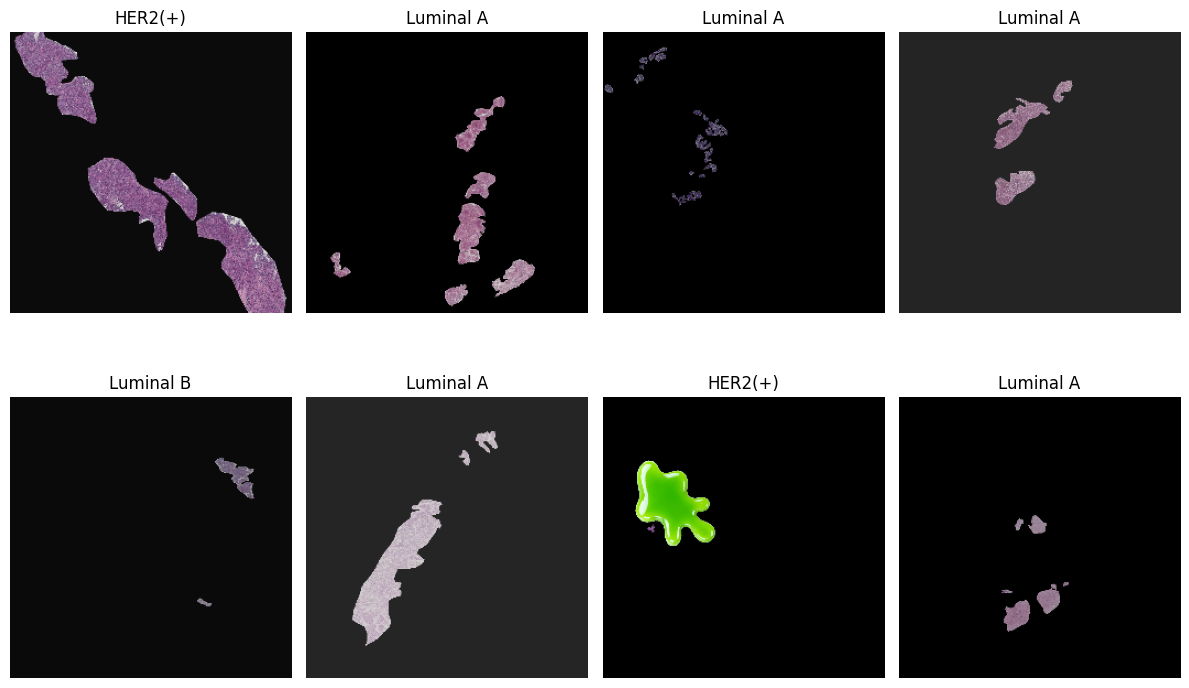

In [ ]:
# ================================================================
# 8. Quick visualization of a batch
# ================================================================
batch_imgs, batch_labels = next(iter(train_ds))

plt.figure(figsize=(12, 8))
for i in range(min(8, batch_imgs.shape[0])):
    plt.subplot(2, 4, i+1)
    plt.imshow(batch_imgs[i].numpy())
    label_idx = tf.argmax(batch_labels[i]).numpy()
    plt.title(id2label[label_idx])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# ================================================================
# 9. Build model with transfer learning
# ================================================================
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess

base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    pooling="avg"
)

base_model.trainable = False  # first stage: freeze backbone

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# Images are in [0,1]; EfficientNet expects 0-255 with its preprocess
x = eff_preprocess(inputs * 255.0)

x = base_model(x, training=False)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,384,679 (16.73 MB)

 Trainable params: 332,036 (1.27 MB)

 Non-trainable params: 4,052,643 (15.46 MB)

In [ ]:
# ================================================================
# 10. Compile model
# ================================================================
# Compute class weights to mitigate class imbalance
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(NUM_CLASSES),
    y=df["label_id"].values
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Callbacks
checkpoint_path = os.path.join(BASE_DIR, "best_model_with_masks.h5")
callbacks = [
    keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor="val_accuracy",
        save_best_only=True,
        mode="max",
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=7,
        mode="max",
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

Class weights: {0: np.float64(0.889168765743073), 1: np.float64(0.8526570048309179), 2: np.float64(0.7932584269662921), 3: np.float64(2.2628205128205128)}


In [ ]:
# ================================================================
# 11. Train classifier head (frozen backbone)
# ================================================================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2754 - loss: 2.3155
Epoch 1: val_accuracy improved from -inf to 0.30389, saving model to /content/drive/MyDrive/ANN_Challenge_2/best_model_with_masks.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 512s 7s/step - accuracy: 0.2752 - loss: 2.3144 - val_accuracy: 0.3039 - val_loss: 1.3841 - learning_rate: 0.0010
Epoch 2/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.3252 - loss: 1.8817
Epoch 2: val_accuracy did not improve from 0.30389
71/71 ━━━━━━━━━━━━━━━━━━━━ 53s 749ms/step - accuracy: 0.3251 - loss: 1.8807 - val_accuracy: 0.2898 - val_loss: 1.4241 - learning_rate: 0.0010
Epoch 3/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.3467 - loss: 1.6189
Epoch 3: val_accuracy improved from 0.30389 to 0.32862, saving model to /content/drive/MyDrive/ANN_Challenge_2/best_model_with_masks.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 54s 757ms/step - accuracy: 0.3466 - loss: 1.6195 - val_accuracy: 0.3286 - val_loss: 1.4152 - learning_rate: 0.0010
Epoch 4/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.3770 - loss: 1.5485
Epoch 4: val_accuracy improved from 0.32862 to 0.34276, saving model to /content/drive/MyDrive/ANN_Challenge_2/best_model_with_masks.h5



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
71/71 ━━━━━━━━━━━━━━━━━━━━ 54s 753ms/step - accuracy: 0.3770 - loss: 1.5483 - val_accuracy: 0.3428 - val_loss: 1.3879 - learning_rate: 0.0010
Epoch 5/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.3388 - loss: 1.4891
Epoch 5: val_accuracy did not improve from 0.34276
71/71 ━━━━━━━━━━━━━━━━━━━━ 82s 754ms/step - accuracy: 0.3391 - loss: 1.4890 - val_accuracy: 0.3145 - val_loss: 1.4145 - learning_rate: 5.0000e-04
Epoch 6/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.3653 - loss: 1.4624
Epoch 6: val_accuracy did not improve from 0.34276
71/71 ━━━━━━━━━━━━━━━━━━━━ 53s 744ms/step - accuracy: 0.3653 - loss: 1.4622 - val_accuracy: 0.3180 - val_loss: 1.4248 - learning_rate: 5.0000e-04
Epoch 7/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.3816 - loss: 1.4057
Epoch 7: val_accuracy did not improve from 0.34276

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
7

In [ ]:
# ================================================================
# 12. Fine-tuning: unfreeze part of the backbone
# ================================================================
base_model.trainable = True

# You can choose how many layers to keep frozen
fine_tune_at = 200  # index in base_model.layers; adjust to your needs

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - accuracy: 0.3085 - loss: 1.7069
Epoch 1: val_accuracy did not improve from 0.34276
71/71 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.3087 - loss: 1.7064 - val_accuracy: 0.3145 - val_loss: 1.4242 - learning_rate: 1.0000e-04
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.3497 - loss: 1.5278
Epoch 2: val_accuracy did not improve from 0.34276
71/71 ━━━━━━━━━━━━━━━━━━━━ 63s 888ms/step - accuracy: 0.3499 - loss: 1.5281 - val_accuracy: 0.2756 - val_loss: 1.5254 - learning_rate: 1.0000e-04
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.3573 - loss: 1.4575
Epoch 3: val_accuracy did not improve from 0.34276
71/71 ━━━━━━━━━━━━━━━━━━━━ 54s 755ms/step - accuracy: 0.3575 - loss: 1.4577 - val_accuracy: 0.2898 - val_loss: 1.5182 - learning_rate: 1.0000e-04
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.3588 - loss: 1.4403
Epoch 4: val_accuracy did not improve from 0.34276

Epoch 4: Reduce

In [ ]:
# ================================================================
# 13. Evaluate on validation and confusion matrix
# ================================================================
val_logits = model.predict(val_ds)
val_pred_ids = np.argmax(val_logits, axis=1)

val_true_ids = val_df["label_id"].values

print(classification_report(val_true_ids, val_pred_ids, target_names=unique_labels))

cm = confusion_matrix(val_true_ids, val_pred_ids)
print(cm)

18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 894ms/step
                 precision    recall  f1-score   support

        HER2(+)       0.39      0.16      0.23        80
      Luminal A       0.42      0.39      0.40        83
      Luminal B       0.34      0.44      0.38        89
Triple negative       0.09      0.16      0.11        31

       accuracy                           0.31       283
      macro avg       0.31      0.29      0.28       283
   weighted avg       0.35      0.31      0.31       283

[[13 20 25 22]
 [ 8 32 35  8]
 [ 9 18 39 23]
 [ 3  7 16  5]]


In [ ]:
# ================================================================
# 14. Build test dataset (use masks, but exclude them from submission list)
# ================================================================
def is_test_image_file(filename: str) -> bool:
    """True for real test images (img_*.png), False for masks."""
    return filename.startswith("img_") and filename.endswith(IMG_EXT)

# List only the real images in test_data
test_image_files = sorted(
    f for f in os.listdir(TEST_IMG_DIR) if is_test_image_file(f)
)

print("Number of test images:", len(test_image_files))
print("First few:", test_image_files[:5])

# Full paths for images & masks
test_img_paths = [os.path.join(TEST_IMG_DIR, fn) for fn in test_image_files]
test_mask_paths = [
    build_mask_path_from_filename(fn).replace(TRAIN_IMG_DIR, TEST_IMG_DIR)
    for fn in test_image_files
]

# Sanity checks
missing_test_imgs  = [p for p in test_img_paths  if not os.path.exists(p)]
missing_test_masks = [p for p in test_mask_paths if not os.path.exists(p)]
print("Missing test images:", len(missing_test_imgs))
print("Missing test masks:", len(missing_test_masks))




# Preprocess for test: image + mask -> masked image only
def preprocess_test(img_path, mask_path):
    """Preprocess test images with masks (no augmentation, no label)."""
    img  = load_image(img_path)
    mask = load_mask(mask_path)

    img  = tf.image.resize(img,  (IMG_SIZE, IMG_SIZE))
    mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
    img  = apply_mask(img, mask)

    return img

test_ds = tf.data.Dataset.from_tensor_slices((test_img_paths, test_mask_paths))
test_ds = test_ds.map(preprocess_test, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

Number of test images: 954
First few: ['img_0000.png', 'img_0001.png', 'img_0002.png', 'img_0003.png', 'img_0004.png']
Missing test images: 0
Missing test masks: 0


In [ ]:
# ================================================================
# 15. Predict on test set and build submission
# ================================================================
test_logits = model.predict(test_ds)
test_pred_ids = np.argmax(test_logits, axis=1)
test_pred_labels = [id2label[idx] for idx in test_pred_ids]


sub_df = pd.DataFrame({
    "sample_index": test_image_files,  # e.g., 'img_0000.png'
    "label": test_pred_labels
})


sub_path = os.path.join(BASE_DIR, "submission_with_masks.csv")
sub_df.to_csv(sub_path, index=False)
print("Saved predictions to:", sub_path)
sub_df.head()

60/60 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step
Saved predictions to: /content/drive/MyDrive/ANN_Challenge_2/submission_with_masks.csv


,sample_index,label
0,img_0000.png,Luminal B
1,img_0001.png,Triple negative
2,img_0002.png,Triple negative
3,img_0003.png,Luminal A
4,img_0004.png,Luminal A
